# Chapter 3. Classification

This chapter will be using MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

In [2]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [3]:
X.shape

(70000, 784)

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
y.shape

(70000,)

Peeking at one digit from the dataset

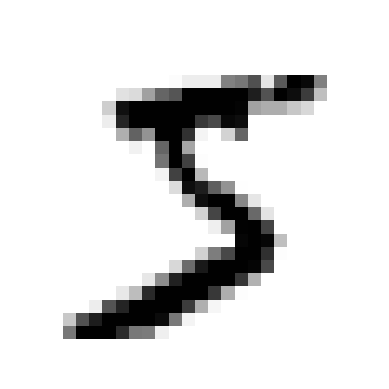

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
# It is a 5 and that is what the label tell us:
y[0]

'5'

In [8]:
# MNIST is already split into training set (first 60k images) and test set
# (last 10k images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

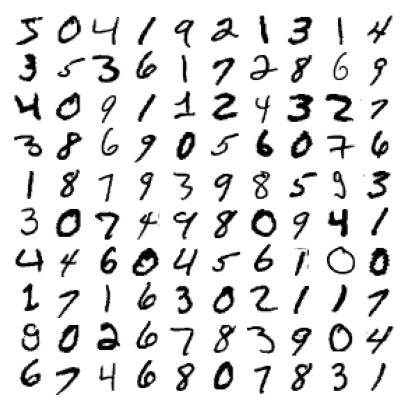

In [9]:
# see 100 images
plt.figure(figsize=(5,5))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10,10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Training a Binary Classifier

Train an ML algorithm to distinguish between 5 and non-5.

In [10]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Train a stochastic gradient descent classifier

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# now we can use it to detect images of the number 5:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

**Measuring Accuracy Using Cross-Validation**

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# creating a dummy classifier and checking its accuracy
from sklearn.dummy import DummyClassifier

# classifier always say the answer is not 5 (False)
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

It has over 90% accuracy! That is because only about 10% of the images are 5s.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when youa re dealing with skewed datasets (when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM)

**Implementing Cross-Validation**

Occasionally you will need more control over the cross-validation
process than what Scikit-Learn provides off the shelf. In these cases,
you can implement cross-validation yourself. The following code does
roughly the same thing as Scikit-Learn’s cross_val_score() function,
and it prints the same result:

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is
                                      # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum (y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


**Confusion Matrices**

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pair. For example,
to know the number of times the classifier confused images of 8s with 0s,
you would look at row #8, column #0 of the confusion matrix.

Tom computer the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual target. You can use the cross_val_predict() function:

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict()
performs k-fold cross-validation, but instead of returning the evaluation
scores, it returns the predictions made on each test fold.

In [18]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [19]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were classifed as non-5s (they are called *true negatives*), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (*false negatives*, also called type II errors), while the remaining 3,539 were correctly classified as 5s (*true positives*).

In [20]:
# perfect confusion matrix with only true positives and true negatives
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Accuracy of positive predictions (called *precision* of the classifier):
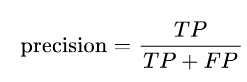


*TP* is the number of true positives, and *FP* is the number of false positives.

Precision is typically used along with another metric named *recall*, also called *sensitivity* or the *true positive rate* (TPR): this is the rationi of positive instances that are correctly detected by the classifer:

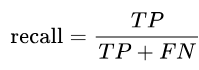

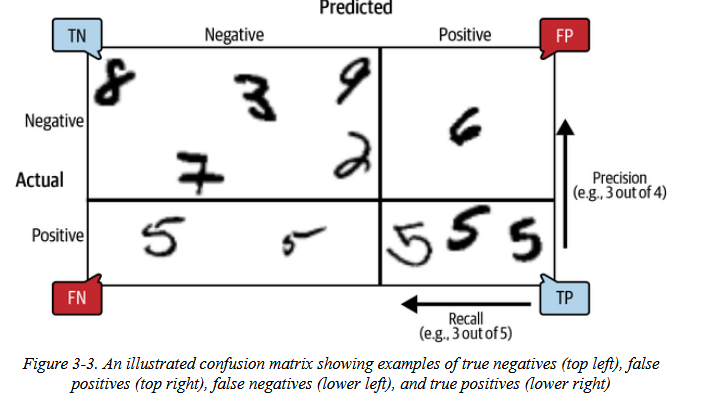

Scikit-Learn provides several functions to compute classifier metrics,
including precision and recall:

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric calld the F1 score, especially when you need a metric to compare 2 classifiers. The F1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F score if both recall and precision are high.

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

To understand this trade-off, let’s look at how the SGDClassifier makes its
classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the
instance to the positive class; otherwise it assigns it to the negative class.

Raise the threshold and precision incraeses and recall decreases. Conversely, lower the threshold and precision decreases and recall increases.

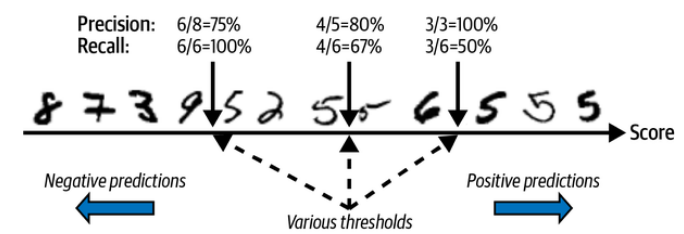

In [24]:
# Sklearn does not let us change the threshold directly but it does give us 
# the scores
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
# low threshold
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
# Raise the threshold
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
# Get all scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                              cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [28]:
# with theses scores use function below to compute precision and recall
# for all possible thresholds
from sklearn.metrics import precision_recall_curve

# the function adds a last precision of 0 and a last recall of 1,
# corresponding to an infinite threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

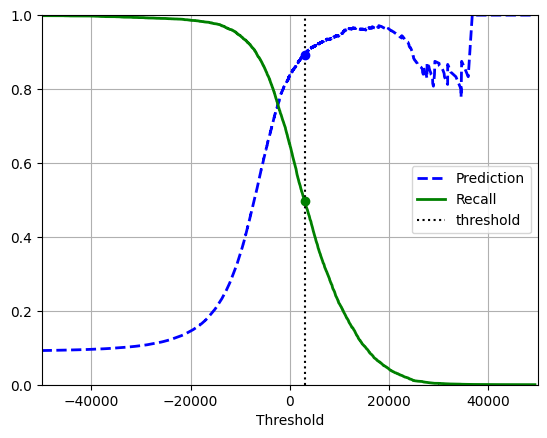

In [29]:
# plot precision and recall as functions of the threshold value while showing 
# the threshold of 3,000
plt.plot(thresholds,precisions[:-1], "b--", label="Prediction", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0,"k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax() # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall (the same threshold is shown):

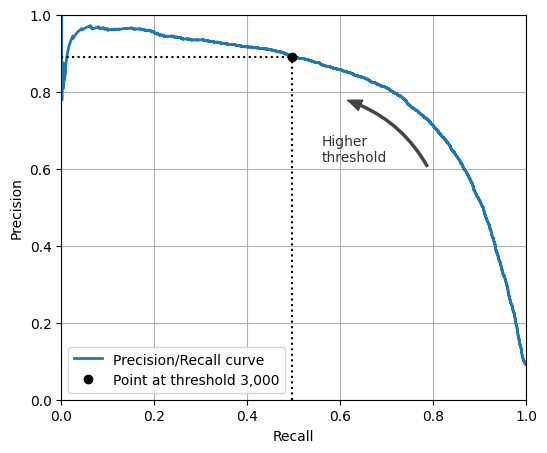

In [30]:
import matplotlib.patches as patches # for the curved arrow

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [31]:
# To select a threshold that gives 90% precision, for example,
# we can search this threshold using NumPy array's argmax() method.
# This returns the first index of the maximum value, which is True here
idx_for_90_precision =  (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [32]:
# To make predictions using our selected threshold:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

# precision and recall
print("Precision:", precision_score(y_train_5, y_train_pred_90))

recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
print("Recall:",recall_at_90_precision)

Precision: 0.9000345901072293
Recall: 0.4799852425751706


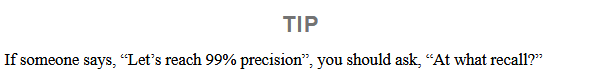

**The ROC Curve**

In [33]:
# use roc_curve() function to compute TPR and FPR
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

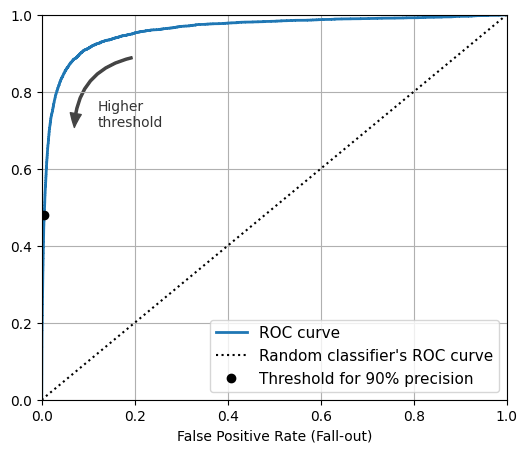

In [34]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1],[0,1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3, rad=0.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel("False Positive Rate (Fall-out)")
plt.grid()
plt.axis([0,1,0,1])
plt.legend(loc="lower right", fontsize=11)

plt.show()

ROC AUC (area under the curve)

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [36]:
# Create RandomForest classifier to compare its PR curve and F1 score
# to those of the SGDClassifier:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [37]:
# use cross val predict to get prediction for every image in the train set
# and get estimated probability
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [38]:
# look at the class probabilities of the the first 2 images in the training set:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [39]:
# second column contains the estimated probabilities for the positive class
# pass them to precision recall curve
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

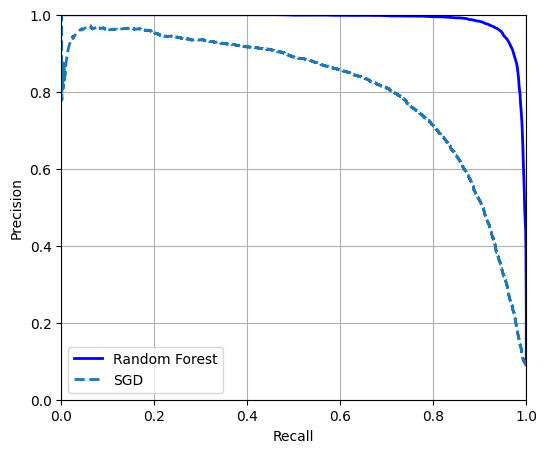

In [40]:
# compare random forest and sgd PR curves
plt.figure(figsize=(6,5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [41]:
# Random forest's PR curve looks much better
# how about F1 score and ROC AUC score?
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%

f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [43]:
# precision and recall scores
print("Precision:", precision_score(y_train_5, y_train_pred_forest))

print("Recall:", recall_score(y_train_5, y_train_pred_forest))

Precision: 0.9897468089558485
Recall: 0.8725327430363402


## Multiclass Classification

In [44]:
# train SVC on first 2k images for the multiclass classification task
# (10 classes)
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

In [45]:
# prediction on a image
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [46]:
# decision function method returns 10 scores per instance: one per class.
# each class gets a score equal to the number of won duels plus or minus a small
# tweak (max ±0.33) to break ties
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [47]:
# highest score is 9.3, and it corresponids to class 5:
class_id = some_digit_scores.argmax()
class_id

5

In [48]:
# if the classes do not match the index of each class in the classes score array
# see the class label array:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [49]:
svm_clf.classes_[class_id]

'5'

In [50]:
# if we want to force scikit-learn to use one-versus-one or one-versus-the-rest
# use OneVsOneClassifier or OneVsRestClassifier classes
from sklearn.multiclass import OneVsRestClassifier

# SVC uses OvO strategy by default
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [51]:
# make a prediction and check the number of trained classifiers:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [52]:
len(ovr_clf.estimators_)

10

In [53]:
# train an SGDClassifier on a multiclass dataset
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [54]:
# Scikit-learn used OvR this time so its decision function method now returns
# one value per class.
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [55]:
# use cross val score to evaluate the model
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Over 85.8% on all test folds. A random classifer would get 10% accuracy. It is good, but we can do better.

In [56]:
# Scaling the inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

See confusion matrix to see the mistakes

In [57]:
# get predictions and save model because I will probably spend days on this notebook and do not want to wait for 20 min to rerun everything every time
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import Memory

location = "./cachedir"
memory = Memory(location, verbose=0)
cross_val_predict_cached = memory.cache(cross_val_predict)

y_train_pred = cross_val_predict_cached(sgd_clf, X_train_scaled, y_train, cv=3)

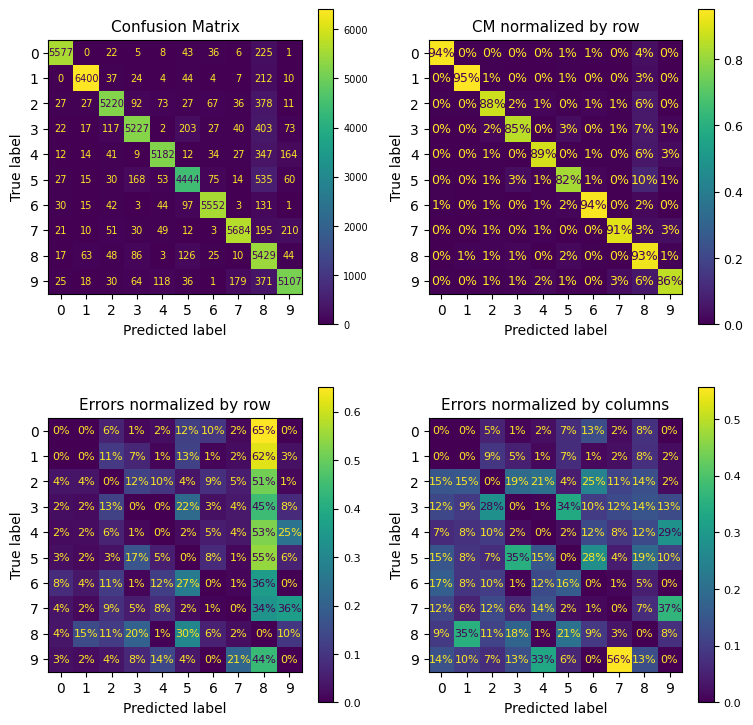

In [58]:
fig, axs = plt.subplots(2,2,figsize=(9,9))

plt.rc("font", size=7)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0][0])
axs[0][0].set_title("Confusion Matrix", fontsize=11)

plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0][1],
                                        normalize="true", values_format=".0%")
axs[0][1].set_title("CM normalized by row")

plt.rc("font", size=8)
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1][0],
                            sample_weight=sample_weight,
                            normalize="true", values_format=".0%")
axs[1][0].set_title("Errors normalized by row", fontsize=11)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1][1],
                            sample_weight=sample_weight,
                            normalize="pred", values_format=".0%")
axs[1][1].set_title("Errors normalized by columns", fontsize=11)
plt.show()
plt.rc("font", size=14) # make fonts great again

In [59]:
# plot 3s and 5s in a confusion matrix style
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

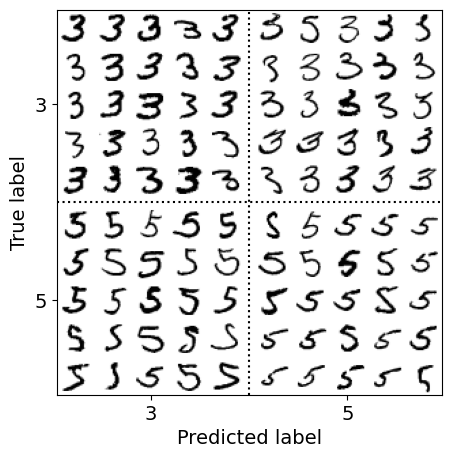

In [60]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0,0)), (X_bb, (1,0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28,28), cmap="binary",
                    extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size /2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Multilabel Classification

In [61]:
# simple example
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype("int8") % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
# prediction
knn_clf.predict([some_digit])

array([[False,  True]])

In [63]:
# compute average F1 score across all labels:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

Example of Chain Classifier:

In [64]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [65]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

In [66]:
# example: add noise to mnist images and the outputs should be the clean
# version of each pixel
np.random.seed(42) # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

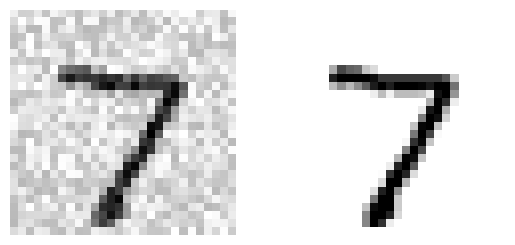

In [67]:
# snooping on test set
plt.subplot(121)
plot_digit(X_test_mod[0])
plt.subplot(122)
plot_digit(y_test_mod[0])

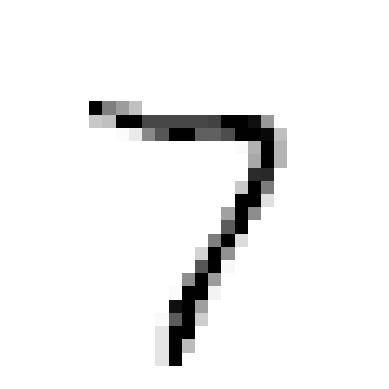

In [68]:
# train a classifier to clean up images
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

# image cleaned up
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

# Exercises

# 1. 

Try to build a classifier for the MNIST dataset that achieves over 97%
accuracy on the test set. Hint: the KNeighborsClassifier works quite
well for this task; you just need to find good hyperparameter values
(try a grid search on the weights and n_neighbors hyperparameters).

In [69]:
from sklearn.model_selection import GridSearchCV

# scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
knn = KNeighborsClassifier()
params = {"weights":["uniform", "distance"], "n_neighbors":[3,4,5,7]}
grid_search = GridSearchCV(knn,params, cv=3, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [70]:
import pandas as pd 

df_knn = pd.DataFrame(grid_search.cv_results_)
df_knn[["params","mean_test_score", "rank_test_score"]].sort_values("rank_test_score").head()

,params,mean_test_score,rank_test_score
3,"{'n_neighbors': 4, 'weights': 'distance'}",0.943767,1
5,"{'n_neighbors': 5, 'weights': 'distance'}",0.942100,2
1,"{'n_neighbors': 3, 'weights': 'distance'}",0.941567,3
4,"{'n_neighbors': 5, 'weights': 'uniform'}",0.940367,4
7,"{'n_neighbors': 7, 'weights': 'distance'}",0.940267,5


In [71]:
# not scaled
params = {"weights":["uniform", "distance"], "n_neighbors":[3, 4, 5, 7]}
grid_search = GridSearchCV(knn,params, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [72]:
df_knn = pd.DataFrame(grid_search.cv_results_)
df_knn[["params","mean_test_score", "rank_test_score"]].sort_values("rank_test_score").head()

,params,mean_test_score,rank_test_score
3,"{'n_neighbors': 4, 'weights': 'distance'}",0.970350,1
1,"{'n_neighbors': 3, 'weights': 'distance'}",0.969333,2
5,"{'n_neighbors': 5, 'weights': 'distance'}",0.968600,3
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.968183,4
4,"{'n_neighbors': 5, 'weights': 'uniform'}",0.967417,5


In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, grid_search.predict(X_test))

0.9714

# 2. 

Write a function that can shift an MNIST image in any direction (left,
right, up, or down) by one pixel. Then, for each image in the training
set, create four shifted copies (one per direction) and add them to the
training set. Finally, train your best model on this expanded training set
and measure its accuracy on the test set. You should observe that your
model performs even better now! This technique of artificially
growing the training set is called data augmentation or training set
expansion.

In [74]:
def shift(x):
    # order: up, down, left, right
    x_up = x.copy()
    x_up[:28**2 - 28] = x_up[28:]
    x_up[28**2 - 28:] = np.zeros(28, dtype=x.dtype)

    x_down = x.copy()
    x_down[28:] = x_down[:28**2 - 28]
    x_down[:28] = np.zeros(28, dtype=x.dtype)

    x_left = x.copy().reshape(28,28)
    x_left[:,:-1] = x_left[:, 1:]
    x_left[:, -1] = np.zeros((28,),dtype=x.dtype)

    x_right = x.copy().reshape(28, 28)
    x_right[:,1:] = x_right[:,:-1]
    x_right[:,0] = np.zeros((1,28), dtype=x.dtype)
    
    return np.array([x, x_up, x_down, x_left.flatten(), x_right.flatten()])

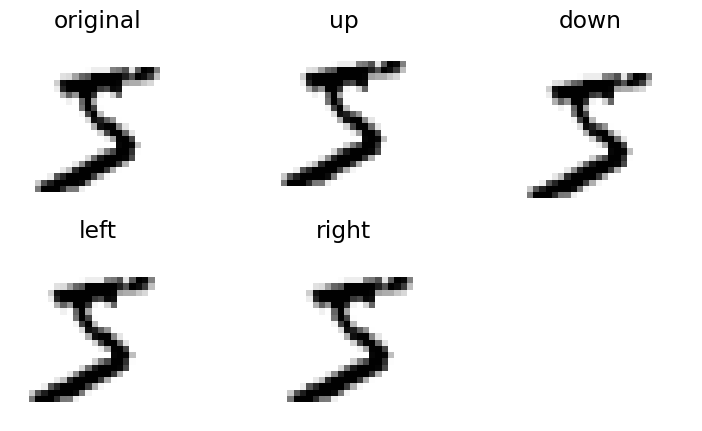

In [75]:
# testing
shifts = shift(some_digit)

titles = ["original", "up", "down", "left", "right"]
fig, axs = plt.subplots(2,3, figsize=(9,5))

for n, img in enumerate(shifts):
    ax = axs[n // 3][n % 3]
    ax.imshow(img.reshape(28,28), cmap="binary")
    ax.axis("off")
    ax.set_title(titles[n])

axs[1][2].axis("off")
plt.show()

In [76]:
X_train_aug = np.zeros((300_000, 784), dtype=X_train.dtype)
y_train_aug = np.empty((300_000,), dtype=y_train.dtype)
for i, img in enumerate(X_train):
    X_train_aug[i*5: (i + 1)*5, :] = shift(img)
    y_train_aug[i*5: (i + 1)*5].fill(y_train[i])
    
print(y_train_aug[:20])
print(y_train[:4])

['5' '5' '5' '5' '5' '0' '0' '0' '0' '0' '4' '4' '4' '4' '4' '1' '1' '1'
 '1' '1']
['5' '0' '4' '1']


In [77]:
from sklearn.utils import shuffle
best_knn = grid_search.best_estimator_ # get best estimator from grid search (97% accuracy on test set)
# shuffle first
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)
best_knn.fit(X_train_aug, y_train_aug)

accuracy_score(y_test, best_knn.predict(X_test))

0.9763

# 3. 

Tackle the Titanic dataset. A great place to start is on Kaggle.
Alternatively, you can download the data from
https://homl.info/titanic.tgz and unzip this tarball like you did for the
housing data in Chapter 2. This will give you two CSV files, train.csv
and test.csv, which you can load using pandas.read_csv(). The goal
is to train a classifier that can predict the Survived column based on
the other columns.

In [78]:
# have to run ch2_TryItOut_titanic.ipynb first for this to work and/or change the CSV files location below if you already have it
train_titanic = pd.read_csv("../ch2/datasets/titanic/train.csv", index_col="PassengerId")
test_titanic = pd.read_csv("../ch2/datasets/titanic/test.csv",index_col="PassengerId")

print("Train shape:", train_titanic.shape)
print("Test shape:", test_titanic.shape)

Train shape: (891, 11)
Test shape: (418, 10)


In [79]:
y_train_titanic = train_titanic["Survived"]
X_train_titanic = train_titanic.drop("Survived", axis=1)
print(y_train_titanic.head())
print(X_train_titanic.head())

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64
             Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   

                Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                                
1              male  22.0      1      0         A/5 21171   7.2500   NaN   
2            female  38.0      1      0          PC 17599  71.2833   C85   
3            female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
4            female  35.0

Since I have already done a lot of data analysis and preprocesing in my other jupyter notebook (ch2_TryItOut_titanic.ipynb), this time I am going to skip data analysis, borrow transformations, and make different transformations on data and train on each one of them.

In every preprocessing pipeline I will: drop name and ticket; create one-hot enconding columns for Pclass and Cabin; Sex will become a binary type column; family column (SibSp + Parch) wil be created; every column will be imputed with either median or mean.

* dataset 1: do only the above and use random forest and logistic regression to drop columns that do not show much correlation (with thresholds: 0.00, 0.01, 0.02, mean, median)
* dataset 2: do above, scale features, and use random forest and logistic regression to drop columns that do not show much correlation (with thresholds: 0.00, 0.01, 0.02, mean, median)

In [80]:
X_train_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


**Creating the pipelines:**

In [81]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline

# from ch2_TryItOut_titanic: pipeline for Cabin
def get_deck(X):
    return X.apply(lambda x: "NA" if pd.isna(x) else x[0])

cabin_pipeline = make_pipeline(FunctionTransformer(pd.DataFrame.apply,feature_names_out="one-to-one", kw_args=dict(func=get_deck)), OneHotEncoder(sparse_output=False))

cabin_pipeline2 = make_pipeline(cabin_pipeline, StandardScaler())

print("Pipeline 1:")
print(cabin_pipeline.fit_transform(X_train_titanic[["Cabin"]]).shape)
print(cabin_pipeline.get_feature_names_out())
print("\nPipeline 2:")
print(cabin_pipeline2.fit_transform(X_train_titanic[["Cabin"]])[:5])

Pipeline 1:
(891, 9)
['Cabin_A' 'Cabin_B' 'Cabin_C' 'Cabin_D' 'Cabin_E' 'Cabin_F' 'Cabin_G'
 'Cabin_NA' 'Cabin_T']

Pipeline 2:
[[-0.13085598 -0.23598136 -0.26629582 -0.19611614 -0.19300938 -0.12168146
  -0.06715343  0.54492498 -0.03352008]
 [-0.13085598 -0.23598136  3.75522235 -0.19611614 -0.19300938 -0.12168146
  -0.06715343 -1.835115   -0.03352008]
 [-0.13085598 -0.23598136 -0.26629582 -0.19611614 -0.19300938 -0.12168146
  -0.06715343  0.54492498 -0.03352008]
 [-0.13085598 -0.23598136  3.75522235 -0.19611614 -0.19300938 -0.12168146
  -0.06715343 -1.835115   -0.03352008]
 [-0.13085598 -0.23598136 -0.26629582 -0.19611614 -0.19300938 -0.12168146
  -0.06715343  0.54492498 -0.03352008]]


In [82]:
# from ch2_TryItOut_titanic: pipeline for Sex
def sex_to_binary(X):
    return X.apply(lambda x: True if x == "male" else False)

sex_pipeline = make_pipeline(FunctionTransformer(pd.DataFrame.apply, feature_names_out="one-to-one", kw_args={"func":sex_to_binary}))

sex_pipeline2 = make_pipeline(sex_pipeline, StandardScaler())

print("Pipeline 1:\n", sex_pipeline.fit_transform(X_train_titanic[["Sex"]]).head())
print("\nPipeline 2:\n", sex_pipeline2.fit_transform(X_train_titanic[["Sex"]])[:5])

Pipeline 1:
                Sex
PassengerId       
1             True
2            False
3            False
4            False
5             True

Pipeline 2:
 [[ 0.73769513]
 [-1.35557354]
 [-1.35557354]
 [-1.35557354]
 [ 0.73769513]]


In [83]:
# from ch2_TryItOut_titanic: pipeline for Age
age_pipeline = make_pipeline(SimpleImputer(strategy="mean"))
age_pipeline2 = make_pipeline(age_pipeline, StandardScaler())

print("Pipeline 1:\n", age_pipeline.fit_transform(X_train_titanic[["Age"]])[:6])
print("\nPipeline 2:\n", age_pipeline2.fit_transform(X_train_titanic[["Age"]])[:6])

Pipeline 1:
 [[22.        ]
 [38.        ]
 [26.        ]
 [35.        ]
 [35.        ]
 [29.69911765]]

Pipeline 2:
 [[-0.5924806 ]
 [ 0.63878901]
 [-0.2846632 ]
 [ 0.40792596]
 [ 0.40792596]
 [ 0.        ]]


In [84]:
# pipeline for pclass, embarked
pclass_embarked_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(sparse_output=False))
pclass_embarked_pipeline2 = make_pipeline(pclass_embarked_pipeline, StandardScaler())

print("Pipeline 1:", pclass_embarked_pipeline.fit_transform(X_train_titanic[["Pclass", "Embarked"]])[:6])
print(pclass_embarked_pipeline.get_feature_names_out())
print("\nPipeline 2:\n", pclass_embarked_pipeline2.fit_transform(X_train_titanic[["Pclass", "Embarked"]])[:5])

Pipeline 1: [[0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0.]]
['Pclass_1' 'Pclass_2' 'Pclass_3' 'Embarked_C' 'Embarked_Q' 'Embarked_S']

Pipeline 2:
 [[-0.56568542 -0.51015154  0.90258736 -0.48204268 -0.30756234  0.61583843]
 [ 1.76776695 -0.51015154 -1.10792599  2.0745051  -0.30756234 -1.62380254]
 [-0.56568542 -0.51015154  0.90258736 -0.48204268 -0.30756234  0.61583843]
 [ 1.76776695 -0.51015154 -1.10792599 -0.48204268 -0.30756234  0.61583843]
 [-0.56568542 -0.51015154  0.90258736 -0.48204268 -0.30756234  0.61583843]]


In [85]:
# pipeline for sibsp, parch, fare
num_pipeline = make_pipeline(SimpleImputer(strategy="median"))
num_pipeline2 = make_pipeline(num_pipeline, StandardScaler())

print("Pipeline 1\n", num_pipeline.fit_transform(X_train_titanic[["SibSp", "Parch", "Fare"]])[:5])
print("\nPipeline 2:\n", num_pipeline2.fit_transform(X_train_titanic[["SibSp", "Parch", "Fare"]])[:5])

Pipeline 1
 [[ 1.      0.      7.25  ]
 [ 1.      0.     71.2833]
 [ 0.      0.      7.925 ]
 [ 1.      0.     53.1   ]
 [ 0.      0.      8.05  ]]

Pipeline 2:
 [[ 0.43279337 -0.47367361 -0.50244517]
 [ 0.43279337 -0.47367361  0.78684529]
 [-0.4745452  -0.47367361 -0.48885426]
 [ 0.43279337 -0.47367361  0.42073024]
 [-0.4745452  -0.47367361 -0.48633742]]


In [86]:
# from ch2_TryItOut_titanic: pipeline for family
def create_column_family(X):
    return X[:,[0]] + X[:,[1]]

def name_family(function_transformer, feature_names_in):
    return ["Family"]

family_pipeline = make_pipeline(SimpleImputer(strategy="median"), FunctionTransformer(create_column_family, feature_names_out=name_family))
family_pipeline2 = make_pipeline(family_pipeline, StandardScaler())

print("Pipeline1:\n", family_pipeline.fit_transform(X_train_titanic[["SibSp", "Parch"]])[:5])
print("\nPipeline2:\n", family_pipeline2.fit_transform(X_train_titanic[["SibSp", "Parch"]])[:5])    

Pipeline1:
 [[1.]
 [1.]
 [0.]
 [1.]
 [0.]]

Pipeline2:
 [[ 0.05915988]
 [ 0.05915988]
 [-0.56097483]
 [ 0.05915988]
 [-0.56097483]]


2 datasets' pipelines:

In [87]:
from sklearn.feature_selection import SelectFromModel

pipe_not_scaled = make_column_transformer((cabin_pipeline, ["Cabin"]),
        (sex_pipeline, ["Sex"]), (age_pipeline,["Age"]),
        (pclass_embarked_pipeline, ["Pclass","Embarked"]),
        (num_pipeline, ["SibSp", "Parch", "Fare"]), 
        (family_pipeline, ["SibSp", "Parch"]))

# pipeline 1
pipe_not_scaled_with_selector = Pipeline([("preprocessing", pipe_not_scaled),
                    ("selector", SelectFromModel(estimator=RandomForestClassifier(),
                                threshold=0))])

pipe_scaled = make_column_transformer((cabin_pipeline2, ["Cabin"]),
        (sex_pipeline2, ["Sex"]), (age_pipeline2,["Age"]),
        (pclass_embarked_pipeline2, ["Pclass","Embarked"]),
        (num_pipeline2, ["SibSp", "Parch", "Fare"]), 
        (family_pipeline2, ["SibSp", "Parch"]))

# pipeline 2
pipe_scaled_with_selector = Pipeline([("preprocessing", pipe_scaled),
                    ("selector", SelectFromModel(estimator=RandomForestClassifier(),
                                threshold=0))])

Setting up all the variables for looping

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

thresholds = [0.00, 0.01, 0.02, "mean", "median"]
pipelines = [pipe_not_scaled_with_selector, pipe_scaled_with_selector]
pipelines_names = ["Not_Scaled", "Scaled"]

models_names = ["Logistic Regression", "Random Forest", "Support Vector Machine", "K-Nearest Neighbors", "Gaussian Naive Bayes"]
models = [LogisticRegression(random_state=42, max_iter=300), RandomForestClassifier(random_state=42), SVC(), KNeighborsClassifier(), GaussianNB()]

list(zip(models_names, models))

[('Logistic Regression', LogisticRegression(max_iter=300, random_state=42)),
 ('Random Forest', RandomForestClassifier(random_state=42)),
 ('Support Vector Machine', SVC()),
 ('K-Nearest Neighbors', KNeighborsClassifier()),
 ('Gaussian Naive Bayes', GaussianNB())]

In [89]:
from sklearn.base import clone 

results = {}
index = []

# creating index
for p_name in pipelines_names:
    for t in thresholds:
        index.append(p_name + "_" + str(t))
        
# loop through each model and save mean of 
# cross_val_score and add results to results dict
for model_name, model in zip(models_names, models):
    results[model_name] = [] # create an array for current model
    for pipe in pipelines: # loop throught the 2 pipelines
        for t in thresholds:
            estimator = clone(model)
            pipe["selector"].set_params(threshold=t) # change threshold (first is 0)
            X_train_preprocessed = pipe.fit_transform(X_train_titanic, y_train_titanic) # preprocessed train set features
            estimator.fit(X_train_preprocessed, y_train_titanic)
            result = cross_val_score(estimator, X_train_preprocessed, y_train_titanic, cv=5, scoring="accuracy", n_jobs=-1).mean()
            results[model_name].append(result)       
            
df_results = pd.DataFrame(results, index=index)
df_results.head(10)

C:\Users\ianvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ianvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,Logistic Regression,Random Forest,Support Vector Machine,K-Nearest Neighbors,Gaussian Naive Bayes
Not_Scaled_0.0,0.796861,0.808116,0.670134,0.710502,0.748685
Not_Scaled_0.01,0.806974,0.808129,0.670134,0.712749,0.758791
Not_Scaled_0.02,0.804695,0.806993,0.671257,0.702643,0.754272
Not_Scaled_mean,0.788996,0.812598,0.672375,0.700414,0.804708
Not_Scaled_median,0.804702,0.810363,0.670134,0.708254,0.765539
Scaled_0.0,0.795738,0.806993,0.798010,0.791269,0.469180
Scaled_0.01,0.800251,0.808116,0.822660,0.812573,0.749802
Scaled_0.02,0.799084,0.813709,0.828272,0.813684,0.754272
Scaled_mean,0.788996,0.814845,0.826044,0.780089,0.804708
Scaled_median,0.803578,0.811500,0.829389,0.810320,0.756544


In [90]:
df_results.mean(axis=1).sort_values(ascending=False) # average accuracy by index, sorted

Scaled_mean          0.802936
Scaled_median        0.802266
Scaled_0.02          0.801804
Scaled_0.01          0.798681
Not_Scaled_mean      0.755818
Not_Scaled_median    0.751798
Not_Scaled_0.01      0.751355
Not_Scaled_0.02      0.747972
Not_Scaled_0.0       0.746860
Scaled_0.0           0.732238
dtype: float64

In [91]:
df_results.max(axis=0).sort_values(ascending=False) # max accuracy by model type, sorted

Support Vector Machine    0.829389
Random Forest             0.814845
K-Nearest Neighbors       0.813684
Logistic Regression       0.806974
Gaussian Naive Bayes      0.804708
dtype: float64

SVMs performed the best yet again when threshold = median and dataset is scaled

**Hyperparameter tuning on SVM**

In [92]:
pipe_scaled_with_selector["selector"].set_params(threshold="median")

param_grid = dict(C=[0.01, 0.1, 0.5, 0.75, 1, 1.25, 1.5, 2, 5, 10, 50, 100],kernel=["linear", "rbf"], class_weight=[None, "balanced"])

grid_search = GridSearchCV(SVC(random_state=42), param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)

X_train_preprocessed = pipe_scaled_with_selector.fit_transform(X_train_titanic, y_train_titanic)

grid_search.fit(X_train_preprocessed, y_train_titanic)

grid_search.best_params_ # not very far from default C value (C=1.0)

{'C': 1.5, 'class_weight': None, 'kernel': 'rbf'}

In [93]:
grid_search.best_score_

0.8316427091833531

In [94]:
X_test_preprocessed = pipe_scaled_with_selector.transform(test_titanic)

y_test_pred = grid_search.best_estimator_.predict(X_test_preprocessed)

df_test_pred = pd.DataFrame(y_test_pred, columns=["Survived"], index=test_titanic.index)

df_test_pred.to_csv("titanic_svm_pred_ch3.csv")

Accuracy is just a little bit better than the previous one (0.77033)

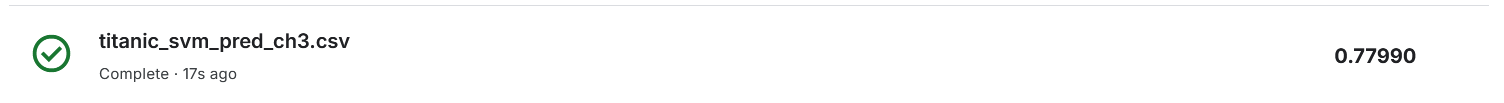

# 4.

Build a spam classifier (a more challenging exercise):

a. Download examples of spam and ham from Apache
SpamAssassin’s public datasets.

b. Unzip the datasets and familiarize yourself with the data format.

c. Split the data into a training set and a test set.

d. Write a data preparation pipeline to convert each email into a
feature vector. Your preparation pipeline should transform an
email into a (sparse) vector that indicates the presence or absence
of each possible word. For example, if all emails only ever
contain four words, “Hello”, “how”, “are”, “you”, then the email
“Hello you Hello Hello you” would be converted into a vector [1,
0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is
absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the
number of occurrences of each word.
You may want to add hyperparameters to your preparation
pipeline to control whether or not to strip off email headers,
convert each email to lowercase, remove punctuation, replace all
URLs with “URL”, replace all numbers with “NUMBER”, or
even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).

e. Finally, try out several classifiers and see if you can build a great
spam classifier, with both high recall and high precision.

website: https://spamassassin.apache.org/old/publiccorpus/

In [95]:
import tarfile
from pathlib import Path

def get_emails_dataset(directory_path: str):
    """directory_path: name of folder containing compressed files or final csv file"""
    directory_path = Path(directory_path)
    path_csv = "datasets/emails.csv"
    if not Path(path_csv).is_file(): # if the csv file had not been created
        for name in directory_path.iterdir(): # get all files in the folder
            if name.is_file():
                with tarfile.open(name, "r:bz2") as file:
                    file.extractall(path="datasets") # and extract all text from it
                    
        # create a dataframe filled with NA with length of 7000 rows (all emails total in the 6000s)
        emails_df = pd.DataFrame(pd.NA, index=range(7000), columns=["Email", "Spam"]) 
        index = 0 # update each row and increment index to be updated
        for folder in directory_path.iterdir():
            # for every directory get all text and put in dataframe
            if folder.is_dir(): 
                # label is 0 (or false) if email is ham
                # 1 if email is spam
                # or skip if folder is not an extraced one
                label = 0 
                if "spam" in folder.name:
                    label = 1
                elif "ham" not in folder.name:
                    continue
                    
                for file in folder.iterdir():
                    if file.is_file() and file.name != "cmds":
                        emails_df.loc[index] = [file.read_text(errors="ignore"), label]
                        index += 1
        emails_df.dropna(inplace=True) # drop unused rows
        # shuffle dataframe and reset index
        emails_df = emails_df.iloc[np.random.default_rng(seed=42).permutation(len(emails_df))].reset_index(drop=True)
        # save dataframe as a comma separated value file
        emails_df.to_csv(path_csv, index=False)
    
        return emails_df
    return pd.read_csv(path_csv)
        

In [96]:
emails_df = get_emails_dataset("datasets")
print(emails_df.shape)
emails_df.head(10)

(6046, 2)


,Email,Spam
0,From exmh-users-admin@redhat.com Mon Sep 23 1...,0
1,From aileen_howard@lycos.com Mon Aug 26 15:49...,1
2,From razor-users-admin@lists.sourceforge.net ...,0
3,From rpm-list-admin@freshrpms.net Mon Sep 9 ...,0
4,From razor-users-admin@lists.sourceforge.net ...,0
5,From spam-request@z1.example.com Sat Oct 5 1...,0
6,From fork-admin@xent.com Mon Sep 30 17:56:13 ...,0
7,From fork-admin@xent.com Mon Sep 23 22:47:31 ...,0
8,From alyssa@lt08.yourip21.com Mon Jul 29 11:3...,1
9,Received: from hq.pro-ns.net (localhost [127.0...,1


In [97]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Email   6046 non-null   object
 1   Spam    6046 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 94.6+ KB


In [98]:
(emails_df["Spam"].value_counts()/len(emails_df)).round(2) # data is imbalanced so I am going to make stratified splits

Spam
0    0.69
1    0.31
Name: count, dtype: float64

In [99]:
from sklearn.model_selection import train_test_split

features = emails_df[["Email"]]
target = emails_df["Spam"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.15, stratify=target, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5139, 1) (907, 1) (5139,) (907,)


In [100]:
(y_train.value_counts()/len(y_train)).round(2) # same ratio as original dataset

Spam
0    0.69
1    0.31
Name: count, dtype: float64

In [101]:
(y_test.value_counts()/len(y_test)).round(2) # same ratio as original dataset

Spam
0    0.69
1    0.31
Name: count, dtype: float64

In [102]:
X_train.head()

,Email
3266,From ilug-admin@linux.ie Mon Sep 2 13:14:40 ...
4706,Return-Path: ticket_erp.b2oaabm1031163663531@s...
435,From ilug-admin@linux.ie Mon Jul 29 11:28:27 ...
4644,From dwftan@earthlink.com Mon Aug 26 15:49:19...
4363,From marymary1965@yahoo.com Tue Aug 6 20:03:...


Now testing the CountVectorizer to create the bag of words

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train["Email"])

print(X_train_vectorized.shape)
vectorizer.get_feature_names_out()

(5139, 151128)


array(['00', '000', '0000', ..., 'ƒœ', 'ƒƒš', 'ˆ65'], dtype=object)

In [104]:
X_train_vectorized.toarray()[:5]

array([[ 2,  0,  0, ...,  0,  0,  0],
       [ 2,  2,  4, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [12, 21,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [105]:
with pd.option_context("display.max_colwidth", None): # now I am seeing what I can do to ignore the text before the actual email
    start_index = X_train["Email"].iloc[0].index("Subject:")
    print(start_index)
    print(len(X_train["Email"].iloc[0]))
    print(len(X_train["Email"].iloc[0][start_index:]))
    print(X_train["Email"].iloc[0][start_index:])

1849
3202
1353
Subject: [ILUG] VPN implementation
Sender: ilug-admin@linux.ie
Errors-To: ilug-admin@linux.ie
X-Mailman-Version: 1.1
Precedence: bulk
List-Id: Irish Linux Users' Group <ilug.linux.ie>
X-Beenthere: ilug@linux.ie

I need to setup a VPN between a few sites. From what I've read, the the
choices come down (on the Linux side) to IPsec (using FreeSWAN) or CIPE.
It seems that FreeSWAN is 'better', being an implementation of IPsec which
is a standard. However, CIPE does the job as well for Linux clients and is
somewhat simpler to setup. 

The problem is that it's not a pure Linux situation - a couple of the sites
run OS-X. I'm pretty sure that I'll be able to find an implementation of
IPsec for OS-X, but I think CIPE is Linux only.

So, the question is for those of you have have implemented BOTH - is there a
significant difference in setup time and hassle between CIPE and FreeSWAN ?
If CIPE is going to be much easier than dealing with FreeSWAN (and whatever
on the OS-X sites) the

In [106]:
# finding out how to pick punctuation too
text_arr = ["I have eaten well! 1 whole pizza", "Do you remember that dog? Well, she is doing better now.", "13 damn dogs...", "A bee lies down"]
vectorizer_test = CountVectorizer(token_pattern="(?u)\\b\\w+\\b|[^\\w\\s]+")
text_arr_vec = vectorizer_test.fit_transform(text_arr)
print(vectorizer_test.get_feature_names_out())
text_arr_vec.toarray()

['!' ',' '.' '...' '1' '13' '?' 'a' 'bee' 'better' 'damn' 'do' 'dog'
 'dogs' 'doing' 'down' 'eaten' 'have' 'i' 'is' 'lies' 'now' 'pizza'
 'remember' 'she' 'that' 'well' 'whole' 'you']


array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [107]:
# regular expressions for token_pattern parameter from CountVectorizer
word_re = r"(?u)\b\w+\b"
word_punc_re = "(?u)\\b\\w+\\b|[^\\w\\s]+"

# regular expressions for preprocessing
url_re = r"\bhttp[a-zA-Z0-9/\.:]+" # it does not detect all of them but at least most of the ones this emails cite
num_re = r"\d+" # detect numbers

In [108]:
# now learning how to apply stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
words_arr = "The fly flies and dies after meeting mules".split()
print(" ".join([stemmer.stem(word) for word in words_arr]))
# stemmer.stem(text_arr[0])
# with pd.option_context("display.max_colwidth", None):
#     start_index = str(X_train.iloc[0]).index("Subject:")
#     print(str(X_train.iloc[0])[start_index:])

the fli fli and die after meet mule


## Pipelines

Hyperparameters: 
* remove email header
* convert email to lowercase (parameter in CountVectorizer)
* CountVectorizer tokenizing punctuation or not
* replace URLs with "URL"
* replace numbers with "NUMBER"
* stemming
* scaler

In [109]:
# remove header pipeline
def remove_header(X):
    return X.apply(lambda X: X[X.index("Subject:"):] if "Subject:" in X else X)
    
remove_header_pipe = make_pipeline(FunctionTransformer(remove_header, feature_names_out="one-to-one"))
# print(remove_header_pipe.transform(X_train["Email"].iloc[0]))
print(remove_header_pipe.transform(X_train["Email"]))

3266    Subject: [ILUG] VPN implementation\nSender: il...
4706    Subject: Struts 1.1 Article, JavaServer Faces ...
435     Subject: Re: [ILUG] weekend projects...\nMessa...
4644    Subject: ADV: Internet marketing & communicati...
4363    Subject: THIS IS A FREE OFFER!\nSender: Mary M...
                              ...                        
5806    Subject: Re: Shatter Attacks - How to break Wi...
1715    Subject: Re: [Razor-users] Razor with sendmail...
5445    Subject: Got plans tonight?\nId-Frugaljoe: zzz...
3288    Subject: RE: Re[2]: Selling Wedded Bliss (was ...
5214    Subject: Best $50 I ever spent!\nX-Mailer: Mic...
Name: Email, Length: 5139, dtype: object


In [110]:
# Testing regex for replacing URLs
import re

url_regex_compiled = re.compile(url_re)
print(url_regex_compiled.findall(X_train["Email"].iloc[0]),"\n")
print(X_train["Email"].iloc[0])

['http://www.linux.ie/mailman/listinfo/ilug'] 

From ilug-admin@linux.ie  Mon Sep  2 13:14:40 2002
Return-Path: <ilug-admin@linux.ie>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 1634847C79
	for <zzzz@localhost>; Mon,  2 Sep 2002 07:42:31 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Mon, 02 Sep 2002 12:42:31 +0100 (IST)
Received: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g82AEwZ28230 for
    <zzzz-ilug@spamassassin.taint.org>; Mon, 2 Sep 2002 11:14:58 +0100
Received: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org
    (8.9.3/8.9.3) with ESMTP id LAA29406; Mon, 2 Sep 2002 11:14:15 +0100
Received: from mail.magicgoeshere.com (nw152-60.indigo.ie [194.125.152.60]
    (may be forged)) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP 

In [111]:
# it did not detect all URLs (only after subject) but we only care about the URLs after "subject"
print(url_regex_compiled.findall(X_train["Email"].iloc[1]),"\n")
print(X_train["Email"].iloc[1])

['http://www.theserverside.com/resources/newsletters/news42.html', 'http://lists.theserverside.com/t/12337/850395/201/181/', 'http://www.TheServerSide.com/resources/newsletters/inreview4.gif', 'http://lists.theserverside.com/t/12337/850395/202/181/', 'http://www.theserverside.com/images/Rational38.gif', 'http://lists.theserverside.com/t/12337/850395/202/181/', 'http://lists.theserverside.com/t/12337/850395/203/181/', 'http://lists.theserverside.com/t/12337/850395/204/181/', 'http://lists.theserverside.com/t/12337/850395/205/181/', 'http://www.theserverside.com/images/dev', 'http://lists.theserverside.com/t/12337/850395/205/181/', 'http://lists.theserverside.com/t/12337/850395/29/181/', 'http://www.theserverside.com/events/videos/common/logo.jpg', 'http://lists.theserverside.com/t/12337/850395/30/181/', 'http://lists.theserverside.com/t/12337/850395/206/181/', 'http://www.theserverside.com/events/videos/AmyFowler/AmySmall.jpg', 'http://lists.theserverside.com/t/12337/850395/206/181/', '

In [112]:
def substitute_text(x, new_word, compiled_regex):
    return x.apply(lambda x: compiled_regex.sub(new_word, x))

func_replace_url = FunctionTransformer(substitute_text,kw_args=dict(new_word="URL", compiled_regex=re.compile(url_re)))
with pd.option_context("display.max_colwidth", None):
    print(X_train["Email"].iloc[0:1])
    print(func_replace_url.transform(X_train["Email"].iloc[0:1])) # it worked!!!

3266    From ilug-admin@linux.ie  Mon Sep  2 13:14:40 2002\nReturn-Path: <ilug-admin@linux.ie>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 1634847C79\n\tfor <zzzz@localhost>; Mon,  2 Sep 2002 07:42:31 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Mon, 02 Sep 2002 12:42:31 +0100 (IST)\nReceived: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g82AEwZ28230 for\n    <zzzz-ilug@spamassassin.taint.org>; Mon, 2 Sep 2002 11:14:58 +0100\nReceived: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org\n    (8.9.3/8.9.3) with ESMTP id LAA29406; Mon, 2 Sep 2002 11:14:15 +0100\nReceived: from mail.magicgoeshere.com (nw152-60.indigo.ie [194.125.152.60]\n    (may be forged)) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id LAA29324\n    for 

In [113]:
# create pipeline
replace_url_pipeline = make_pipeline(FunctionTransformer(substitute_text, kw_args=dict(new_word="URL", compiled_regex=re.compile(url_re)), feature_names_out="one-to-one"))

replace_url_pipeline.fit_transform(X_train["Email"].iloc[0:1])

3266    From ilug-admin@linux.ie  Mon Sep  2 13:14:40 ...
Name: Email, dtype: object

In [114]:
# finding numbers
num_re_compiled = re.compile(num_re)

print(num_re_compiled.findall(X_train["Email"].iloc[0]))
print(X_train["Email"].iloc[0])

['2', '13', '14', '40', '2002', '127', '0', '0', '1', '1634847', '79', '2', '2002', '07', '42', '31', '0400', '127', '0', '0', '1', '5', '9', '0', '02', '2002', '12', '42', '31', '0100', '194', '125', '145', '45', '8', '11', '6', '8', '11', '6', '82', '28230', '2', '2002', '11', '14', '58', '0100', '127', '0', '0', '1', '8', '9', '3', '8', '9', '3', '29406', '2', '2002', '11', '14', '15', '0100', '152', '60', '194', '125', '152', '60', '8', '9', '3', '8', '9', '3', '29324', '2', '2002', '11', '13', '49', '0100', '152', '60', '194', '125', '152', '60', '15', '158', '194', '125', '176', '158', '15675', '4', '2', '2002', '10', '57', '18', '0100', '501', '05', '61', '2', '2002', '11', '00', '17', '0100', '2', '2002', '11', '00', '17', '0100', '20020902100017', '2041', '1', '0', '1', '3', '27', '1', '1']
From ilug-admin@linux.ie  Mon Sep  2 13:14:40 2002
Return-Path: <ilug-admin@linux.ie>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos

In [115]:
# pipeline for replacing number
num_replace_pipeline = make_pipeline(FunctionTransformer(substitute_text, kw_args=dict(new_word="NUMBER", compiled_regex=re.compile(num_re)), feature_names_out="one-to-one"))

with pd.option_context("display.max_colwidth", None):
    print(num_replace_pipeline.transform(X_train["Email"].iloc[0:1]))

3266    From ilug-admin@linux.ie  Mon Sep  NUMBER NUMBER:NUMBER:NUMBER NUMBER\nReturn-Path: <ilug-admin@linux.ie>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [NUMBER.NUMBER.NUMBER.NUMBER])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id NUMBERCNUMBER\n\tfor <zzzz@localhost>; Mon,  NUMBER Sep NUMBER NUMBER:NUMBER:NUMBER -NUMBER (EDT)\nReceived: from phobos [NUMBER.NUMBER.NUMBER.NUMBER]\n\tby localhost with IMAP (fetchmail-NUMBER.NUMBER.NUMBER)\n\tfor zzzz@localhost (single-drop); Mon, NUMBER Sep NUMBER NUMBER:NUMBER:NUMBER +NUMBER (IST)\nReceived: from lugh.tuatha.org (root@lugh.tuatha.org [NUMBER.NUMBER.NUMBER.NUMBER]) by\n    dogma.slashnull.org (NUMBER.NUMBER.NUMBER/NUMBER.NUMBER.NUMBER) with ESMTP id gNUMBERAEwZNUMBER for\n    <zzzz-ilug@spamassassin.taint.org>; Mon, NUMBER Sep NUMBER NUMBER:NUMBER:NUMBER +NUMBER\nReceived: from lugh (root@localhost [NUMBER.NUMBER.NUMBER.NUMBER]) by lugh.tuatha.org\n    (NUMBER.NUMBER.NUMBER/NUMBER.NUMB

In [116]:
# pipeline for stemming
def apply_stem(X):
    return X.apply(stem_text,args=(PorterStemmer(), re.compile(word_re)))
    
def stem_text(x, stemmer, word_re_compiled):
    # separate text into "words"
    sep_words = x.split()
    # regex object takes only the word from the string, stemmer stems it, then new word replaces old word
    # i am doing this in case that the word comes with a comma and stemmer does not stems it 
    # ex: passing "mules," to stemmer does not work. It has to be only "mules" to get "mule"
    # it does separate "it's", for example, but that is ok since it won't separate it in any text
    # the idea is just to save the same "appearance" of each word and their derivations
    for i, word in enumerate(sep_words):
        word_parts = word_re_compiled.findall(word)
        if word_parts:
            for word_part in word_parts:
                word = word.replace(word_part, PorterStemmer().stem(word_part))
        sep_words[i] = word
    return " ".join(sep_words)

stemming_pipeline = make_pipeline(FunctionTransformer(apply_stem, feature_names_out="one-to-one"))

with pd.option_context("display.max_colwidth", None):
    print(stemming_pipeline.transform(X_train["Email"].iloc[0:1]))

3266    from ilug-admin@linux.ie mon sep 2 13:14:40 2002 return-path: <ilug-admin@linux.ie> deliv-to: zzzz@localhost.netnoteinc.com receiv: from localhost (localhost [127.0.0.1]) by phobo.lab.netnoteinc.com (postfix) with esmtp id 1634847c79 for <zzzz@localhost>; mon, 2 sep 2002 07:42:31 -0400 (edt) receiv: from phobo [127.0.0.1] by localhost with imap (fetchmail-5.9.0) for zzzz@localhost (singl-drop); mon, 02 sep 2002 12:42:31 +0100 (ist) receiv: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by dogma.slashnul.org (8.11.6/8.11.6) with esmtp id g82aewz28230 for <zzzz-ilug@spamassassin.taint.org>; mon, 2 sep 2002 11:14:58 +0100 receiv: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org (8.9.3/8.9.3) with esmtp id laa29406; mon, 2 sep 2002 11:14:15 +0100 receiv: from mail.magicgoesher.com (nw152-60.indigo.ie [194.125.152.60] (may be forg)) by lugh.tuatha.org (8.9.3/8.9.3) with esmtp id laa29324 for <ilug@linux.ie>; mon, 2 sep 2002 11:13:49 +0100 x-authent-warn: lugh.

## Hyperparameter tuning preprocessing

In [117]:
%%time
model = Pipeline([("url",replace_url_pipeline),
                  ("num",num_replace_pipeline), ("stemming", stemming_pipeline),
                  ("vectorizer", CountVectorizer()), ("scaler", StandardScaler(with_mean=False)),
                  ("classifier", RandomForestClassifier(random_state=42))])

param_grid = {"url":["passthrough", replace_url_pipeline], "num": ["passthrough",num_replace_pipeline],
        "stemming":["passthrough", stemming_pipeline], "vectorizer__lowercase":[False, True],
        "vectorizer__token_pattern":[word_punc_re, word_re],
        "scaler": ["passthrough", StandardScaler(with_mean=False)]}

X_train_no_header = remove_header_pipe.transform(X_train["Email"]) # I am always removing the header
grid_search = GridSearchCV(model, param_grid=param_grid, scoring="f1", cv=3, n_jobs=-1)
grid_search.fit(X_train_no_header, y_train)

CPU times: total: 2min 17s
Wall time: 25min 10s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('url',
                                        Pipeline(steps=[('functiontransformer',
                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                             func=<function substitute_text at 0x000001CDC2F4E3E0>,
                                                                             kw_args={'compiled_regex': re.compile('\\bhttp[a-zA-Z0-9/\\.:]+'),
                                                                                      'new_word': 'URL'}))])),
                                       ('num',
                                        Pipeline(steps=[('functiontransformer',
                                                         FunctionTransformer(feat...
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function substitute_text at 0x000001CDC2F4E3E0>,
                                                                      kw_args={'compiled_regex': re.compile('\\bhttp[a-zA-Z0-9/\\.:]+'),
                                                                               'new_word': 'URL'}))])],
                         'vectorizer__lowercase': [False, True],
                         'vectorizer__token_pattern': ['(?u)\\b\\w+\\b|[^\\w\\s]+',
                                                       '(?u)\\b\\w+\\b']},
             scoring='f1')

In [118]:
results_preprocessing_df = pd.DataFrame(grid_search.cv_results_)

columns = ["param_num", "param_scaler", "param_stemming", "param_url","param_vectorizer__lowercase",
           "param_vectorizer__token_pattern", "mean_test_score", "rank_test_score"]

results_preprocessing_df[columns] .sort_values("rank_test_score").head()

,param_num,param_scaler,param_stemming,param_url,param_vectorizer__lowercase,param_vectorizer__token_pattern,mean_test_score,rank_test_score
47,(FunctionTransformer(feature_names_out='one-to...,passthrough,(FunctionTransformer(feature_names_out='one-to...,(FunctionTransformer(feature_names_out='one-to...,True,(?u)\b\w+\b,0.958816,1
12,passthrough,passthrough,(FunctionTransformer(feature_names_out='one-to...,(FunctionTransformer(feature_names_out='one-to...,False,(?u)\b\w+\b|[^\w\s]+,0.958498,2
63,(FunctionTransformer(feature_names_out='one-to...,StandardScaler(with_mean=False),(FunctionTransformer(feature_names_out='one-to...,(FunctionTransformer(feature_names_out='one-to...,True,(?u)\b\w+\b,0.958491,3
30,passthrough,StandardScaler(with_mean=False),(FunctionTransformer(feature_names_out='one-to...,(FunctionTransformer(feature_names_out='one-to...,True,(?u)\b\w+\b|[^\w\s]+,0.958137,4
14,passthrough,passthrough,(FunctionTransformer(feature_names_out='one-to...,(FunctionTransformer(feature_names_out='one-to...,True,(?u)\b\w+\b|[^\w\s]+,0.958137,4


In [119]:
results_preprocessing_df[columns] .sort_values("rank_test_score").tail()

,param_num,param_scaler,param_stemming,param_url,param_vectorizer__lowercase,param_vectorizer__token_pattern,mean_test_score,rank_test_score
53,(FunctionTransformer(feature_names_out='one-to...,StandardScaler(with_mean=False),passthrough,(FunctionTransformer(feature_names_out='one-to...,False,(?u)\b\w+\b,0.953000,60
31,passthrough,StandardScaler(with_mean=False),(FunctionTransformer(feature_names_out='one-to...,(FunctionTransformer(feature_names_out='one-to...,True,(?u)\b\w+\b,0.952731,61
37,(FunctionTransformer(feature_names_out='one-to...,passthrough,passthrough,(FunctionTransformer(feature_names_out='one-to...,False,(?u)\b\w+\b,0.952079,62
5,passthrough,passthrough,passthrough,(FunctionTransformer(feature_names_out='one-to...,False,(?u)\b\w+\b,0.951055,63
21,passthrough,StandardScaler(with_mean=False),passthrough,(FunctionTransformer(feature_names_out='one-to...,False,(?u)\b\w+\b,0.951055,63


Worst model...
* did not replace numbers with NUM
* scaled bag of words
* did not stem the words
* replaced urls with URL
* did not convert words to lowercase
* token pattern ignored punctuaction
* mean f1 score is 0.951

Best model...
* replaced numbers with NUM
* did not scale bag of words
* stemmed words
* replaced urls with URL
* converted words to lowercase
* ignored punctuation
* mean f1 score is 0.959

The difference is not that big, but I am using the hyperparameters of rank 1 model

## Finding best model

In [120]:
%%time
# finding best model
from sklearn.naive_bayes import MultinomialNB
model_best_preprocessing = Pipeline([("url",replace_url_pipeline),
                  ("num",num_replace_pipeline), ("stemming", stemming_pipeline),
                  ("vectorizer", CountVectorizer(token_pattern=word_re)),
                  ("classifier", RandomForestClassifier(random_state=42))])
param_grid = {"classifier":[LogisticRegression(random_state=42), RandomForestClassifier(random_state=42), SVC(), KNeighborsClassifier(), MultinomialNB()]}

grid_search_best_model = GridSearchCV(model_best_preprocessing, param_grid=param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search_best_model.fit(X_train_no_header,y_train)

CPU times: total: 1min 43s
Wall time: 8min 34s


C:\Users\ianvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('url',
                                        Pipeline(steps=[('functiontransformer',
                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                             func=<function substitute_text at 0x000001CDC2F4E3E0>,
                                                                             kw_args={'compiled_regex': re.compile('\\bhttp[a-zA-Z0-9/\\.:]+'),
                                                                                      'new_word': 'URL'}))])),
                                       ('num',
                                        Pipeline(steps=[('functiontransformer',
                                                         FunctionTransformer(feat...
                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                             func=<function apply_stem at 0x000001CDC2F4F740>))])),
                                       ('vectorizer',
                                        CountVectorizer(token_pattern='(?u)\\b\\w+\\b')),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier': [LogisticRegression(random_state=42),
                                        RandomForestClassifier(random_state=42),
                                        SVC(), KNeighborsClassifier(),
                                        MultinomialNB()]},
             scoring='f1')

In [121]:
results_models_df = pd.DataFrame(grid_search_best_model.cv_results_)

columns = ["param_classifier", "mean_test_score", "rank_test_score"]

results_models_df[columns].sort_values("rank_test_score")

,param_classifier,mean_test_score,rank_test_score
0,LogisticRegression(random_state=42),0.973054,1
1,RandomForestClassifier(random_state=42),0.966032,2
4,MultinomialNB(),0.919540,3
3,KNeighborsClassifier(),0.913210,4
2,SVC(),0.786409,5


Best model is Logistic Regression even though the bag of words is not scaled.

## Fine-tuning best model

In [122]:
# ignore warnings logistic regression might raise due to non-convergence
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [123]:
# preprocessing
X_train_preprocessed = model_best_preprocessing[:-1].fit_transform(X_train_no_header) # [:-1] ignore the model, I just want to preprocess the data
X_train_preprocessed.shape

(5139, 81466)

In [124]:
%%time
# using random search to fine tune model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# training when the data is not scaled first
distrib = {"C": randint(low=1,high=100),
           "max_iter": randint(low=50, high=300),}
random_search_not_scaled = RandomizedSearchCV(LogisticRegression(random_state=42), param_distributions=distrib, n_iter=200, cv=5, random_state=42, scoring="f1", n_jobs=-1)

random_search_not_scaled.fit(X_train_preprocessed, y_train)

CPU times: total: 22.1 s
Wall time: 15min 11s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CE04C07DA0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CE04C071D0>},
                   random_state=42, scoring='f1')

In [125]:
%%time
# training on scaled data
logreg = Pipeline([("scale",StandardScaler(with_mean=False)), ("log", LogisticRegression(random_state=42))])

distrib = {"log__C": randint(low=1,high=100),
           "log__max_iter": randint(low=50, high=300),}
random_search_scaled = RandomizedSearchCV(logreg, param_distributions=distrib, n_iter=200, cv=5, random_state=42, scoring="f1", n_jobs=-1)

random_search_scaled.fit(X_train_preprocessed, y_train)

CPU times: total: 9.28 s
Wall time: 2min 13s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scale',
                                              StandardScaler(with_mean=False)),
                                             ('log',
                                              LogisticRegression(random_state=42))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'log__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CDFD0335C0>,
                                        'log__max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CE2A30AA80>},
                   random_state=42, scoring='f1')

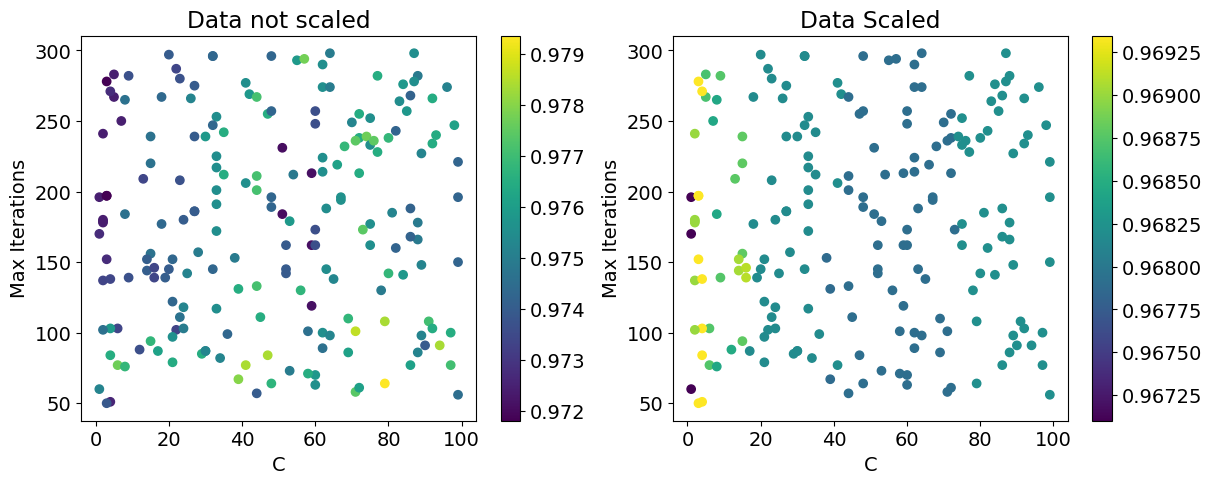

In [126]:
results_logreg1 = random_search_not_scaled.cv_results_
results_logreg2 = random_search_scaled.cv_results_

plt.figure(figsize=(14,5))

plt.subplot(121)
plt.scatter(results_logreg1["param_C"], results_logreg1["param_max_iter"], c=results_logreg1["mean_test_score"])
plt.colorbar()
plt.title("Data not scaled")
plt.xlabel("C")
plt.ylabel("Max Iterations")

plt.subplot(122)
plt.scatter(results_logreg2["param_log__C"], results_logreg2["param_log__max_iter"], c=results_logreg2["mean_test_score"])
plt.colorbar()
plt.title("Data Scaled")
plt.xlabel("C")
plt.ylabel("Max Iterations")

plt.show()

Not scaling the data is actually better even for Logistic Regression

In [127]:
# F1-score of best model
random_search_not_scaled.best_score_

0.9793577896950849

## Removing features

One last thing before using the test set, let's if using Random Forest to remove the least important features improves performance

In [128]:
rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [129]:
rfc.feature_importances_.max() # Need to know maximum value to create proper grid for grid search

0.011882242426382299

In [130]:
%%time
pipeline_with_selector = Pipeline([("selector",SelectFromModel(estimator=RandomForestClassifier(random_state=42), threshold=0)),
                                   ("classifer", random_search_not_scaled.best_estimator_)])
threshold_list = [0] + [str(x) + "*" + "median" for x in np.linspace(0.5,1.5)]
param_grid = {"selector__threshold": threshold_list}

grid_search_selector = GridSearchCV(pipeline_with_selector, cv=5, n_jobs=-1,scoring="f1", param_grid=param_grid)

grid_search_selector.fit(X_train_preprocessed, y_train)

CPU times: total: 19.1 s
Wall time: 9min 45s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                        threshold=0)),
                                       ('classifer',
                                        LogisticRegression(C=79, max_iter=64,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'selector__threshold': [0, '0.5*median',
                                                 '0.5204081632653061*median',
                                                 '0.5408163265306123*median',
                                                 '0.5612244897959183*median',
                                                 '...
                                                 '0.846938775510204*median',
                                                 '0.8673469387755102*median',
                                                 '0.8877551020408163*median',
                                                 '0.9081632653061225*median',
                                                 '0.9285714285714286*median',
                                                 '0.9489795918367346*median',
                                                 '0.9693877551020408*median',
                                                 '0.9897959183673469*median',
                                                 '1.010204081632653*median',
                                                 '1.030612244897959*median',
                                                 '1.0510204081632653*median',
                                                 '1.0714285714285714*median', ...]},
             scoring='f1')

In [131]:
results_selector_df = pd.DataFrame(grid_search_selector.cv_results_)

results_selector_df[["param_selector__threshold","mean_test_score", "rank_test_score"]].sort_values("rank_test_score").head() 

,param_selector__threshold,mean_test_score,rank_test_score
0,0,0.979358,1
27,1.030612244897959*median,0.979358,1
28,1.0510204081632653*median,0.979358,1
29,1.0714285714285714*median,0.979358,1
30,1.0918367346938775*median,0.979358,1


At least it was a good try =D

# Test score

In [132]:
X_test_no_header = remove_header_pipe.transform(X_test["Email"])
X_test_preprocessed = model_best_preprocessing[:-1].transform(X_test_no_header)
predictions_test = grid_search_selector.best_estimator_.predict(X_test_preprocessed)

In [133]:
print("Accuracy:",accuracy_score(y_test, predictions_test))
print("F1 score:",f1_score(y_test, predictions_test))
print("Precision:", precision_score(y_test, predictions_test))
print("Recall:", recall_score(y_test, predictions_test))

Accuracy: 0.9922822491730982
F1 score: 0.9876977152899824
Precision: 0.9859649122807017
Recall: 0.9894366197183099


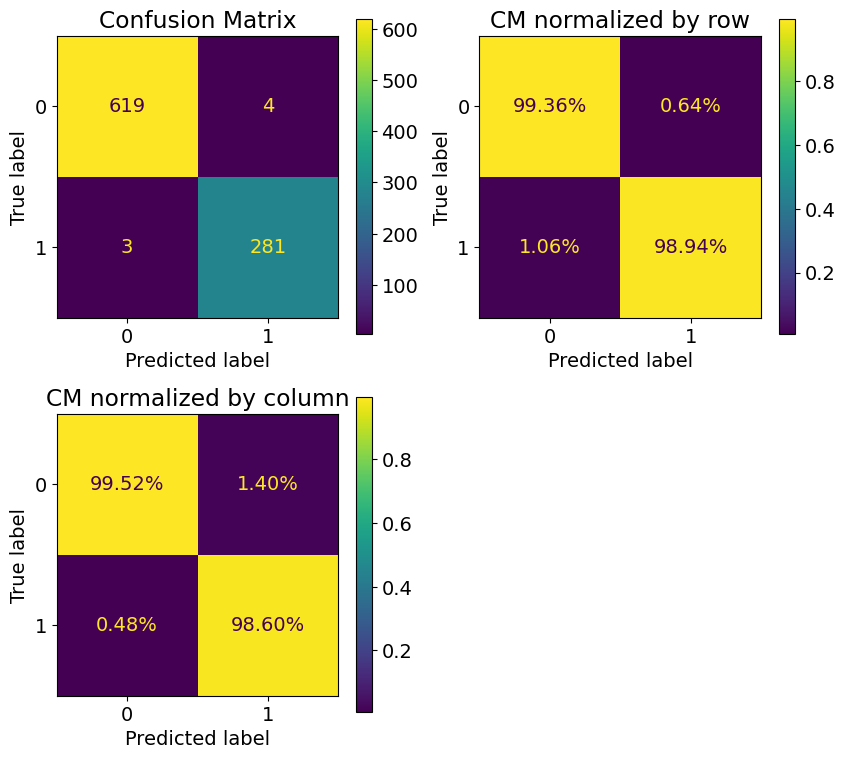

In [134]:
fig, axs = plt.subplots(2,2,figsize=(10,9))

ConfusionMatrixDisplay.from_predictions(y_test, predictions_test, ax=axs[0][0])
axs[0][0].set_title("Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_test, predictions_test, ax=axs[0][1], normalize="true", values_format=".2%")
axs[0][1].set_title("CM normalized by row")

ConfusionMatrixDisplay.from_predictions(y_test, predictions_test, ax=axs[1][0], normalize="pred", values_format=".2%")
axs[1][0].set_title("CM normalized by column")

axs[1][1].axis("off")

plt.show()

# Exercise solutions by Author

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

In [135]:
# loading dataset
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's start with a simple K-Nearest Neighbors classifier and measure its performance on the test set. This will be our baseline:

In [136]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

Great! A regular KNN classifier with the default hyperparameters is already very close to our goal.

Let's see if tuning the hyperparameters can help. To speed up the search, let's train only on the first 10,000 images:

In [137]:
from sklearn.model_selection import GridSearchCV

param_grid = {"weights": ["uniform", "distance"],
               "n_neighbors": [3, 4, 5, 6]}

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6],
                         'weights': ['uniform', 'distance']})

In [138]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [139]:
grid_search.best_score_

0.9441999999999998

The score dropped, but that was expected since we only trained on 10,000 images. So let's take the best model and train it again on the full training set:

In [140]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

We reached our goal of 97% accuracy! 🥳

# 2. Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

Let's try augmenting the MNIST dataset by adding slightly shifted versions of each image.

In [141]:
from scipy.ndimage import shift

In [142]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Let's see if it works:

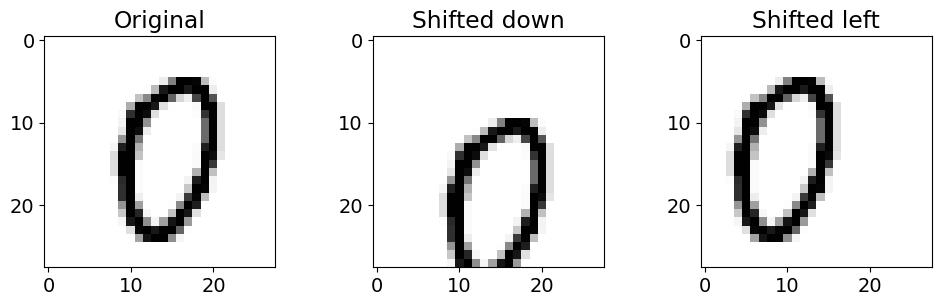

In [143]:
image = X_train[1000] # some ranodm digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28,28),
            interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28,28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

Looks good! Now let's create an augmented training set by shifting every image left, right, up and down by one pixel:

In [144]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1,0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

Let's shuffle the augmented training set, or else all shifted images will be grouped together:

In [145]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Now let's train the model using the best hyperparameters we found in the previous exercise:

In [146]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [147]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

Warning: the following cell may take a few minutes to run:

In [148]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

By simply augmenting the data, we've got a 0.5% accuracy boost. Perhaps it does not sound so impressive, but it actually means that the error rate dropped significantly:

In [149]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change: .0%}")

error_rate_change = -17%


The error rate dropped quite a bit thanks to data augmentation.

## 3. Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

In [150]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("titanic/titanic.tgz")
    if not tarball_path.is_file():
        Path("titanic").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="titanic")
    return [pd.read_csv(Path("titanic/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [151]:
train_data, test_data = load_titanic_data()

The data is already split into a training set and a test set. However, the test data does not contain the labels: your goal is to train the best model you can on the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [152]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

Let's explicitly set the `PassengerId` column as the index column:

In [153]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Let's get more info to see how much data is missing:

In [154]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [155]:
train_data[train_data["Sex"] == "female"]["Age"].median()

27.0

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [156]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Yikes, only 38% **Survived**! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [157]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [158]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [159]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [160]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

Now we can build the pipeline for the categorical attributes:

In [162]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

Note: the `sparse` hyperparameter below was renamed to `sparse_output`.

In [163]:
cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False)),
])

Finally, let's join the numerical and categorical pipelines:

In [164]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [165]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Let's not forget to get the labels:

In [166]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with a `RandomForestClassifier`:

In [167]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Great, our model is trained, let's use it to make predictions on the test set:

In [168]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format expected by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [169]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

Okay, not too bad! Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that our score is in the top 2%, woohoo! Some Kagglers reached 100% accuracy, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! 😆

Let's try an `SVC`:

In [170]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Great! This model looks better.

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

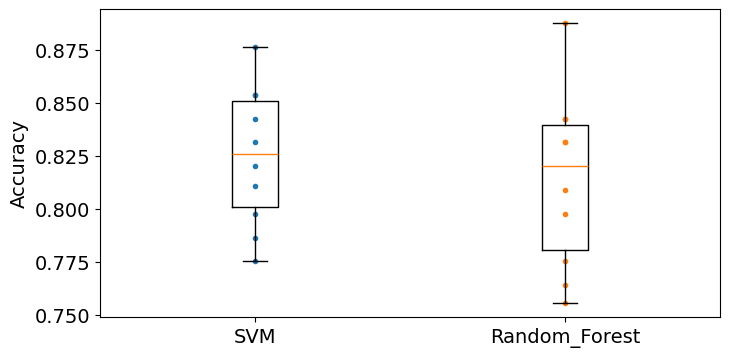

In [171]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=("SVM", "Random_Forest"))
plt.ylabel("Accuracy")
plt.show()

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.
  * Try to identify parts of names that correlate well with the **Survived** attribute.
  * Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

In [172]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [173]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ["RelativesOnboard"]).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. Spam classifier

Exercise: _Build a spam classifier (a more challenging exercise):_

* _Download examples of spam and ham from [Apache SpamAssassin's public datasets](https://homl.info/spamassassin)._
* _Unzip the datasets and familiarize yourself with the data format._
* _Split the datasets into a training set and a test set._
* _Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word._

_You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with "URL," replace all numbers with "NUMBER," or even perform _stemming_ (i.e., trim off word endings; there are Python libraries available to do this)._

_Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision._

In [174]:
import tarfile

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "spam_ham" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            
            with tarfile.open(path) as tar_bz2_file:
                tar_bz2_file.extractall(path=spam_path)

    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [175]:
ham_dir, spam_dir = fetch_spam_data()

Next, let's load all the emails:

In [176]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [177]:
len(ham_filenames)

2500

In [178]:
len(spam_filenames)

500

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [179]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [180]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [181]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [182]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [183]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [184]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [185]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [186]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [187]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the Subject header:

In [188]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [189]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [195]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub("<head.*?>.*?</head>", "", html, flags= re.M | re.S | re.I)
    text = re.sub(r"<a\s.*?>", " HYPERLINK ", text, flags= re.M | re.S | re.I)
    text = re.sub("<.*?>", "", text, flags=re.M | re.S)
    text = re.sub(r"(\s*\n)+", "\n", text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [197]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [198]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [199]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [200]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Let's throw in some stemming! We will use the Natural Language Toolkit (NLTK):

In [201]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library:

In [202]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [214]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r"\d+(?:\.\d*)?(?:[eE][+-]?\d+)?", "NUMBER", text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [215]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [218]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                    for index, (word, count) in enumerate(most_common)}

        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
        shape=(len(X), self.vocabulary_size + 1))

In [219]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 20 stored elements and shape (3, 11)>

In [220]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [221]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [222]:
%%time
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

CPU times: total: 1min 1s
Wall time: 1min 3s


In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.985

Over 98.5%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [225]:
X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 96.88%
Recall: 97.89%
